# Vector Database Performance Comparison

This notebook compares the search performance of Milvus, Weaviate, Qdrant, and a Brute-Force method.
The comparison is based on:
- Randomly generated vectors.
- Varying dataset sizes (number of vectors).
- Cosine similarity as the distance metric.
- Measurement of both insertion time and search time.

**Prerequisites:**
- Ensure Milvus, Weaviate, and Qdrant services are running (e.g., via the `all_databases_docker_compose.yml`).
- The necessary Python client libraries are installed.

In [1]:
# 1. Install Dependencies
# Uncomment and run the following line if you haven't installed the packages yet.
!pip install pymilvus weaviate-client qdrant-client numpy matplotlib tqdm scikit-learn pandas


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 2. Imports and Configuration
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import gc  # For garbage collection
import time

# Database Connection Parameters
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"
MILVUS_COLLECTION_NAME = "performance_test_milvus"

WEAVIATE_URL = "http://localhost:8080" # Default from your docker-compose
WEAVIATE_CLASS_NAME = "PerformanceTestItem"

QDRANT_HOST = "127.0.0.1"
QDRANT_PORT = 6333
QDRANT_COLLECTION_NAME = "performance_test_qdrant"

# Experiment Parameters
VECTOR_DIMENSION = 128  # Example dimension, adjust as needed
NUM_VECTORS_TO_TEST = [1000, 10000, 100000, 1000000, 2000000, 5000000]  # Number of vectors to test
TOP_K = 10  # Number of nearest neighbors to retrieve
NUM_QUERIES = 10 # Number of random queries to average search time over
DATA_INSERTION_BATCH_SIZE = 50000  # Number of vectors to generate and insert in each batch
MAX_BRUTE_FORCE_VECTORS = 5000000  # Skip brute-force for N > this to avoid OOM
MAX_WEAVIATE_VECTORS = 1000000  # Skip Weaviate for N > this to avoid OOM

# For reproducibility
np.random.seed(42)

# Ensure data directory exists for results
RESULTS_DIR = "performance_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

## Helper Functions

In [3]:
# 3.1. Data Generation
def generate_random_vectors(num_vectors, dim):
    """Generates num_vectors of dim-dimensional random vectors, L2 normalized."""
    vectors = np.random.rand(num_vectors, dim).astype(np.float32)
    # Normalize for cosine similarity (equivalent to IP on normalized vectors)
    norm = np.linalg.norm(vectors, axis=1, keepdims=True)
    # Handle potential division by zero if a vector is all zeros
    vectors = np.divide(vectors, norm, out=np.zeros_like(vectors), where=norm!=0)
    return vectors

def generate_ids(num_vectors, start_id=0):
    """Generates a list of unique integer IDs starting from start_id."""
    return list(range(start_id, start_id + num_vectors))

In [4]:
# 3.2. Brute-Force Search
def brute_force_search(query_vector, data_vectors, top_k):
    """
    Performs brute-force search using cosine similarity.
    Assumes query_vector and data_vectors are L2 normalized.
    """
    # Cosine similarity for normalized vectors is dot product
    # similarities = np.dot(data_vectors, query_vector)
    similarities = [np.dot(query_vector, vec) for vec in data_vectors]
    similarities = np.array(similarities)
    # Get top_k indices (sort descending, take top k)
    # Using argpartition for efficiency to find top k, then sort only those k
    if len(similarities) == 0:  # Handle empty data_vectors
        return np.array([]), np.array([])
    if len(similarities) <= top_k:
        sorted_indices = np.argsort(similarities)[::-1]
    else:
        # Get indices of the k largest values
        indices_of_top_k = np.argpartition(similarities, -top_k)[-top_k:]
        # Sort these k indices by their similarity values
        sorted_indices = indices_of_top_k[np.argsort(similarities[indices_of_top_k])[::-1]]
    
    return sorted_indices, similarities[sorted_indices]

In [5]:
# 3.3. Milvus Helper Functions
from pymilvus import connections, utility, Collection, CollectionSchema, FieldSchema
from pymilvus import DataType as MilvusDataType

def setup_milvus(collection_name, dim):
    # Connection is now handled globally in the experiment section
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
        print(f"Dropped existing Milvus collection: {collection_name}")

    fields = [
        FieldSchema(name="id", dtype=MilvusDataType.INT64, is_primary=True, auto_id=False),
        FieldSchema(name="vector", dtype=MilvusDataType.FLOAT_VECTOR, dim=dim)
    ]
    schema = CollectionSchema(fields, description="Performance test collection for Milvus")
    collection = Collection(collection_name, schema=schema)
    
    # Use HNSW index for better search performance
    index_params = {
        "metric_type": "IP",  # Inner Product, equivalent to Cosine for normalized vectors
        "index_type": "HNSW", # Better for search performance than AUTOINDEX
        "params": {
            "M": 16,           # Number of bidirectional links for each node
            "efConstruction": 200  # Higher value means higher index quality but slower build
        }
    }
    collection.create_index(field_name="vector", index_params=index_params)
    print(f"Milvus collection '{collection_name}' created with HNSW index.")
    return collection

def insert_into_milvus(collection, ids, vectors):
    entities = [ids, vectors]
    insert_result = collection.insert(entities)
    # Removing flush from here - will be done once after all batches
    return len(insert_result.primary_keys)

def search_milvus(collection, query_vector, top_k):
    # collection.load() is now called once before the search loop
    search_params = {
        "metric_type": "IP",
        "params": {
            "ef": 100  # Increasing search scope improves recall but slows search
        }
    }
    results = collection.search(
        data=[query_vector],
        anns_field="vector",
        param=search_params,
        limit=top_k,
        expr=None, # No filtering
        consistency_level="Strong"
    )
    # collection.release() is now called once after all searches
    return results

In [6]:
# 3.4. Weaviate Helper Functions
import weaviate
from weaviate import Client
from weaviate.classes.config import Configure, Property, VectorDistances
from  weaviate.classes.config import DataType as WeaviateDataType

def setup_weaviate(client, class_name, dim):
    try:
        # Check if class exists and delete it if it does
        if client.collections.exists(class_name):
            client.collections.delete(class_name)
            print(f"Dropped existing Weaviate class: {class_name}")
    except Exception as e:
        print(f"Warning: Could not delete class {class_name} - may not exist yet: {e}")

    # Configure HNSW parameters for better search performance
    # Create new class with the class name
    collection = client.collections.create(
        name=class_name,
        properties=[
            Property(name="identifier", data_type=WeaviateDataType.INT, description="Unique int ID")
        ],
        # Configure vector index settings
        vector_index_config=Configure.VectorIndex.hnsw(
            ef_construction=128,
            distance_metric=VectorDistances.COSINE
        ),
    )
    print(f"Created Weaviate class '{class_name}' with HNSW configuration.")
    return collection

# def insert_into_weaviate(client, class_name, ids, vectors):
#     # Get the collection
#     collection = client.collections.get(class_name)
#     # Create batch
#     with collection.batch.dynamic() as batch:
#         for id_val, vec in zip(ids, vectors):
#             # Create object with properties and vector
#             batch.add_object(
#                 properties={"identifier": int(id_val)},
#                 vector=vec.tolist()  # Ensure vector is a list
#             )
    
#     return len(ids)  # Weaviate batch doesn't return count directly, assume all succeed

def insert_into_weaviate(
    client: Client,
    class_name: str,
    ids: list[int],
    vectors: np.ndarray,
    batch_size: int = 50000,
    thread_count: int = 8
) -> int:
    """
    Insert nhanh vào Weaviate:
    - Gán batch_size, thread_count, dynamic ngay trong context.
    """
    collection = client.collections.get(class_name)

    with collection.batch.dynamic() as batch:
        # Cấu hình batch sau khi vào context
        batch.batch_size   = batch_size
        batch.thread_count = thread_count
        batch.dynamic      = True
        batch.progress     = False

        for id_val, vec in zip(ids, vectors):
            batch.add_object(
                properties={"identifier": int(id_val)},
                vector=vec.tolist()
            )

    return len(ids)


def search_weaviate(client, class_name, query_vector, top_k):
    # Get the collection
    collection = client.collections.get(class_name)
    # Perform vector search
    query_result = collection.query.near_vector(
        near_vector=query_vector.tolist(),
        limit=top_k,
        return_properties=["identifier"]
    )
    
    return query_result

In [7]:
# 3.5. Qdrant Helper Functions
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest
from qdrant_client.http.models import Distance, VectorParams, HnswConfigDiff, OptimizersConfigDiff, PointStruct

def setup_qdrant(client, collection_name, dim):
    try:
        # Try to get collection info to check if it exists
        if client.collection_exists(collection_name=collection_name):
            client.delete_collection(collection_name=collection_name)
            print(f"Dropped existing Qdrant collection: {collection_name}")
    except Exception as e: # More generic catch as specific exception for not found might vary
        print(f"Could not delete Qdrant collection {collection_name} (may not exist): {e}")

    # Configure HNSW parameters for better search performance
    client.create_collection(
        collection_name=collection_name,
        vectors_config=rest.VectorParams(
            size=dim, 
            distance=rest.Distance.COSINE
        ),
        hnsw_config=rest.HnswConfigDiff(
            m=16,               # Number of bidirectional links created for each new element
            ef_construct=200,   # Size of the dynamic candidate list for construction
        ),
        optimizers_config=rest.OptimizersConfigDiff(
            indexing_threshold=10000,  # Start indexing after this many vectors
        )
    )
    print(f"Qdrant collection '{collection_name}' created with optimized HNSW parameters.")

# def insert_into_qdrant(client, collection_name, ids, vectors):
#     # Qdrant expects payloads, we can use the ID as a simple payload or skip if not needed
#     points = [rest.PointStruct(id=int(id_val), vector=vector.tolist(), payload={"id": int(id_val)}) for id_val, vector in zip(ids, vectors)]
#     # Use wait=False for faster async insertion (we'll ensure indexing completes before search)
#     client.upsert(collection_name=collection_name, points=points, wait=False)
#     return len(points)

def insert_into_qdrant(
    client: QdrantClient,
    collection_name: str,
    ids: list[int],
    vectors: np.ndarray,
    batch_size: int = 50000
) -> int:
    """
    Insert lớn vào Qdrant:
    - Upsert async cho tất cả batch, nhưng chỉ chờ batch cuối.
    """
    total = 0
    n = len(ids)
    for i in range(0, n, batch_size):
        chunk_ids = ids[i : i + batch_size]
        chunk_vec = vectors[i : i + batch_size]
        points = [
            PointStruct(id=int(_id), vector=v.tolist(), payload={"id": int(_id)})
            for _id, v in zip(chunk_ids, chunk_vec)
        ]
        # wait=True chỉ cho batch cuối, thay thế wait_collection_ready không tồn tại
        is_last = (i + batch_size) >= n
        client.upsert(
            collection_name=collection_name,
            points=points,
            wait=is_last
        )
        total += len(points)

    return total

def search_qdrant(client, collection_name, query_vector, top_k):
    # Use optimized search parameters
    search_result = client.search(
        collection_name=collection_name,
        query_vector=query_vector.tolist(),
        limit=top_k,
        search_params=rest.SearchParams(
            hnsw_ef=128  # Increasing ef improves recall at the cost of latency
        )
    )
    return search_result

## Experiment Execution

In [8]:
# --- Milvus Client Initialization ---
try:
    connections.connect(
        host=MILVUS_HOST, 
        port=MILVUS_PORT, 
        timeout=10, 
    )
    print("Successfully connected to Milvus for experiment.")
    milvus_client_available = True
except Exception as e:
    print(f"Failed to connect to Milvus: {e}. Milvus tests will be skipped.")
    milvus_client_available = False

# --- Weaviate Client Initialization ---
try:
    # Import weaviate for v4 client
    import weaviate
    
    # Initialize client with v4 API
    weaviate_client = weaviate.connect_to_local()
    
    # Check if client is ready
    if not weaviate_client.is_ready():
        raise Exception("Weaviate client not ready")
    print("Successfully connected to Weaviate for experiment.")
    weaviate_client_available = True
except Exception as e:
    print(f"Failed to connect to Weaviate: {e}. Weaviate tests will be skipped.")
    weaviate_client_available = False

# --- Qdrant Client Initialization ---
try:
    qdrant_clientx = QdrantClient(
        host="127.0.0.1",
        port=6334,
        prefer_grpc=True,
        timeout=30
    )
    # Try a simple operation to check connection, e.g., list collections
    qdrant_clientx.get_collections()
    print("Successfully connected to Qdrant for experiment.")
    qdrant_client_available = True
except Exception as e:
    print(f"Failed to connect to Qdrant: {e}. Qdrant tests will be skipped.")
    qdrant_client_available = False

Successfully connected to Milvus for experiment.
Successfully connected to Weaviate for experiment.
Successfully connected to Qdrant for experiment.


In [9]:
# Initialize results storage
results = []
query_vectors_cache = {} 


for num_vectors_total in NUM_VECTORS_TO_TEST:
    print(f"\n--- Testing with {num_vectors_total} vectors (Dimension: {VECTOR_DIMENSION}) ---")
    
    # Generate or retrieve cached query vectors
    # Query vectors are generated once per num_vectors_total to ensure fair comparison for search
    if num_vectors_total not in query_vectors_cache:
        print(f"Generating {NUM_QUERIES} query vectors for N={num_vectors_total}...")
        query_vectors_cache[num_vectors_total] = generate_random_vectors(NUM_QUERIES, VECTOR_DIMENSION)
    query_vectors_for_current_size = query_vectors_cache[num_vectors_total]

    # --- Milvus Test ---
    if milvus_client_available:
        try:
            print("\nRunning Milvus Test...")
            milvus_collection = setup_milvus(MILVUS_COLLECTION_NAME, VECTOR_DIMENSION)
            milvus_total_insert_time = 0
            
            print(f"Milvus: Inserting {num_vectors_total} vectors in batches of {DATA_INSERTION_BATCH_SIZE}...")
            for i in tqdm(range(0, num_vectors_total, DATA_INSERTION_BATCH_SIZE), desc="Milvus Inserting Batches"):
                batch_start_id = i
                actual_batch_size = min(DATA_INSERTION_BATCH_SIZE, num_vectors_total - i)
                if actual_batch_size == 0: continue

                batch_ids = generate_ids(actual_batch_size, start_id=batch_start_id)
                batch_vectors = generate_random_vectors(actual_batch_size, VECTOR_DIMENSION)

                start_time_batch = time.time()
                insert_into_milvus(milvus_collection, batch_ids, batch_vectors)
                milvus_total_insert_time += (time.time() - start_time_batch)
            
            print("Milvus: Flushing all inserted data...")
            start_flush_time = time.time()
            milvus_collection.flush()
            milvus_total_insert_time += (time.time() - start_flush_time) # Add final flush time
            print(f"Milvus total insertion and flush time: {milvus_total_insert_time:.4f}s")

            print("Milvus: Loading collection for search...")
            milvus_collection.load()
            search_times = []
            for q_vec in tqdm(query_vectors_for_current_size, desc="Milvus Searching"):
                start_time_search = time.time()
                search_milvus(milvus_collection, q_vec, TOP_K)
                search_times.append(time.time() - start_time_search)
            milvus_avg_search_time = np.mean(search_times) if search_times else np.nan
            milvus_collection.release()
            print(f"Milvus average search time: {milvus_avg_search_time:.6f}s")
            
            results.append({"db": "Milvus", "vectors": num_vectors_total, "insert_time": milvus_total_insert_time, "search_time": milvus_avg_search_time})
            utility.drop_collection(MILVUS_COLLECTION_NAME)

        except Exception as e:
            print(f"Error during Milvus test for {num_vectors_total} vectors: {e}")
            results.append({"db": "Milvus", "vectors": num_vectors_total, "insert_time": np.nan, "search_time": np.nan})

    # --- Weaviate Test ---
    if weaviate_client_available and num_vectors_total <= MAX_WEAVIATE_VECTORS:
        try:
            print("\nRunning Weaviate Test...")
            setup_weaviate(weaviate_client, WEAVIATE_CLASS_NAME, VECTOR_DIMENSION)
            weaviate_total_insert_time = 0
            
            print(f"Weaviate: Inserting {num_vectors_total} vectors in batches of {DATA_INSERTION_BATCH_SIZE}...")
            for i in tqdm(range(0, num_vectors_total, DATA_INSERTION_BATCH_SIZE), desc="Weaviate Inserting Batches"):
                batch_start_id = i
                actual_batch_size = min(DATA_INSERTION_BATCH_SIZE, num_vectors_total - i)
                if actual_batch_size == 0: continue
                
                batch_ids = generate_ids(actual_batch_size, start_id=batch_start_id)
                batch_vectors = generate_random_vectors(actual_batch_size, VECTOR_DIMENSION)

                start_time_batch = time.time()
                insert_into_weaviate(weaviate_client, WEAVIATE_CLASS_NAME, batch_ids, batch_vectors)
                weaviate_total_insert_time += (time.time() - start_time_batch)
            print(f"Weaviate insertion time: {weaviate_total_insert_time:.4f}s")

            search_times = []
            for q_vec in tqdm(query_vectors_for_current_size, desc="Weaviate Searching"):
                start_time_search = time.time()
                search_weaviate(weaviate_client, WEAVIATE_CLASS_NAME, q_vec, TOP_K)
                search_times.append(time.time() - start_time_search)
            weaviate_avg_search_time = np.mean(search_times) if search_times else np.nan
            print(f"Weaviate average search time: {weaviate_avg_search_time:.6f}s")

            results.append({"db": "Weaviate", "vectors": num_vectors_total, "insert_time": weaviate_total_insert_time, "search_time": weaviate_avg_search_time})
            # Weaviate cleanup
            if weaviate_client.collections.exists(WEAVIATE_CLASS_NAME):
                weaviate_client.collections.delete(WEAVIATE_CLASS_NAME)
                print(f"Dropped Weaviate class: {WEAVIATE_CLASS_NAME}")
        except Exception as e:
            print(f"Error during Weaviate test for {num_vectors_total} vectors: {e}")
            results.append({"db": "Weaviate", "vectors": num_vectors_total, "insert_time": np.nan, "search_time": np.nan})

    # --- Qdrant Test ---
    if qdrant_client_available:
        try:
            print("\nRunning Qdrant Test...")
            setup_qdrant(qdrant_clientx, QDRANT_COLLECTION_NAME, VECTOR_DIMENSION)
            qdrant_total_insert_time = 0

            print(f"Qdrant: Inserting {num_vectors_total} vectors in batches of {DATA_INSERTION_BATCH_SIZE}...")
            for i in tqdm(range(0, num_vectors_total, DATA_INSERTION_BATCH_SIZE), desc="Qdrant Inserting Batches"):
                batch_start_id = i
                actual_batch_size = min(DATA_INSERTION_BATCH_SIZE, num_vectors_total - i)
                if actual_batch_size == 0: continue

                batch_ids = generate_ids(actual_batch_size, start_id=batch_start_id)
                batch_vectors = generate_random_vectors(actual_batch_size, VECTOR_DIMENSION)
            
                start_time_batch = time.time()
                insert_into_qdrant(qdrant_clientx, QDRANT_COLLECTION_NAME, batch_ids, batch_vectors)
                qdrant_total_insert_time += (time.time() - start_time_batch)
            
            print(f"Qdrant insertion time (async upsert): {qdrant_total_insert_time:.4f}s")

            # Add a small wait to ensure all vectors are indexed after async insertion
            time.sleep(1)

            search_times = []
            for q_vec in tqdm(query_vectors_for_current_size, desc="Qdrant Searching"):
                start_time_search = time.time()
                search_qdrant(qdrant_clientx, QDRANT_COLLECTION_NAME, q_vec, TOP_K)
                search_times.append(time.time() - start_time_search)
            qdrant_avg_search_time = np.mean(search_times) if search_times else np.nan
            print(f"Qdrant average search time: {qdrant_avg_search_time:.6f}s")
            
            results.append({"db": "Qdrant", "vectors": num_vectors_total, "insert_time": qdrant_total_insert_time, "search_time": qdrant_avg_search_time})
            qdrant_clientx.delete_collection(collection_name=QDRANT_COLLECTION_NAME)
        except Exception as e:
            print(f"Error during Qdrant test for {num_vectors_total} vectors: {e}")
            results.append({"db": "Qdrant", "vectors": num_vectors_total, "insert_time": np.nan, "search_time": np.nan})
            
    # --- Brute-Force Test ---
    print("\nRunning Brute-Force Test...")
    brute_force_insert_time = 0 # Considered negligible as data is just held in memory
    brute_force_avg_search_time = np.nan
    all_data_vectors_for_brute_force = None # Initialize

    if num_vectors_total > MAX_BRUTE_FORCE_VECTORS:
        print(f"Skipping Brute-Force data generation and search for {num_vectors_total} vectors (exceeds MAX_BRUTE_FORCE_VECTORS={MAX_BRUTE_FORCE_VECTORS}).")
    else:
        temp_brute_force_vectors_list = []
        print(f"Brute-Force: Generating {num_vectors_total} vectors for search...")
        for i in tqdm(range(0, num_vectors_total, DATA_INSERTION_BATCH_SIZE), desc="Generating Brute-Force Data"):
            actual_batch_size = min(DATA_INSERTION_BATCH_SIZE, num_vectors_total - i)
            if actual_batch_size == 0: continue
            batch_vectors = generate_random_vectors(actual_batch_size, VECTOR_DIMENSION)
            temp_brute_force_vectors_list.append(batch_vectors)
        
        if temp_brute_force_vectors_list:
             all_data_vectors_for_brute_force = np.concatenate(temp_brute_force_vectors_list)
        else:
             all_data_vectors_for_brute_force = np.array([]).reshape(0, VECTOR_DIMENSION)
        temp_brute_force_vectors_list = None # Free memory

        search_times_bf = []
        if all_data_vectors_for_brute_force is not None and all_data_vectors_for_brute_force.shape[0] > 0:
            for q_vec in tqdm(query_vectors_for_current_size, desc="Brute-Force Searching"):
                start_time_bf_search = time.time()
                brute_force_search(q_vec, all_data_vectors_for_brute_force, TOP_K)
                search_times_bf.append(time.time() - start_time_bf_search)
            brute_force_avg_search_time = np.mean(search_times_bf) if search_times_bf else np.nan
        print(f"Brute-force average search time: {brute_force_avg_search_time:.6f}s")
    
    results.append({"db": "Brute-Force", "vectors": num_vectors_total, "insert_time": brute_force_insert_time, "search_time": brute_force_avg_search_time})
    if all_data_vectors_for_brute_force is not None:
        del all_data_vectors_for_brute_force # Explicitly delete to free memory
        all_data_vectors_for_brute_force = None
    gc.collect() # Force garbage collection to free memory

# Convert results to DataFrame for easier plotting and analysis
results_df = pd.DataFrame(results)
print("\n--- Experiment Complete ---")
if not results_df.empty:
    print(results_df)
    # Save results to CSV
    csv_filename = os.path.join(RESULTS_DIR, f"performance_dim{VECTOR_DIMENSION}_top{TOP_K}_batch{DATA_INSERTION_BATCH_SIZE}.csv")
    results_df.to_csv(csv_filename, index=False)
    print(f"Results saved to {csv_filename}")
else:
    print("No results were generated.")


--- Testing with 1000 vectors (Dimension: 128) ---
Generating 10 query vectors for N=1000...

Running Milvus Test...
Milvus collection 'performance_test_milvus' created with HNSW index.
Milvus: Inserting 1000 vectors in batches of 50000...


Milvus Inserting Batches: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Milvus: Flushing all inserted data...
Milvus total insertion and flush time: 3.3648s
Milvus: Loading collection for search...


Milvus Searching: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Milvus average search time: 0.369010s

Running Weaviate Test...
Created Weaviate class 'PerformanceTestItem' with HNSW configuration.
Weaviate: Inserting 1000 vectors in batches of 50000...


Weaviate Inserting Batches: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Weaviate insertion time: 1.6444s


Weaviate Searching: 100%|██████████| 10/10 [00:00<00:00, 622.27it/s]


Weaviate average search time: 0.001592s
Dropped Weaviate class: PerformanceTestItem

Running Qdrant Test...
Qdrant collection 'performance_test_qdrant' created with optimized HNSW parameters.
Qdrant: Inserting 1000 vectors in batches of 50000...


Qdrant Inserting Batches: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Qdrant insertion time (async upsert): 0.2071s


Qdrant Searching:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\hokha\AppData\Local\Temp\ipykernel_14876\151612134.py:72: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(
Qdrant Searching: 100%|██████████| 10/10 [00:00<00:00, 608.62it/s]


Qdrant average search time: 0.001634s

Running Brute-Force Test...
Brute-Force: Generating 1000 vectors for search...


Brute-Force Searching: 100%|██████████| 10/10 [00:00<00:00, 987.24it/s]


Brute-force average search time: 0.000987s

--- Testing with 10000 vectors (Dimension: 128) ---
Generating 10 query vectors for N=10000...

Running Milvus Test...
Milvus collection 'performance_test_milvus' created with HNSW index.
Milvus: Inserting 10000 vectors in batches of 50000...


Milvus Inserting Batches: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Milvus: Flushing all inserted data...
Milvus total insertion and flush time: 3.3623s
Milvus: Loading collection for search...


Milvus Searching: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Milvus average search time: 0.403123s

Running Weaviate Test...
Created Weaviate class 'PerformanceTestItem' with HNSW configuration.
Weaviate: Inserting 10000 vectors in batches of 50000...


Weaviate Inserting Batches: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


Weaviate insertion time: 4.0083s


Weaviate Searching: 100%|██████████| 10/10 [00:00<00:00, 336.88it/s]


Weaviate average search time: 0.002926s
Dropped Weaviate class: PerformanceTestItem

Running Qdrant Test...
Qdrant collection 'performance_test_qdrant' created with optimized HNSW parameters.
Qdrant: Inserting 10000 vectors in batches of 50000...


Qdrant Inserting Batches: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Qdrant insertion time (async upsert): 2.0466s


Qdrant Searching: 100%|██████████| 10/10 [00:00<00:00, 341.24it/s]


Qdrant average search time: 0.002881s

Running Brute-Force Test...
Brute-Force: Generating 10000 vectors for search...


Brute-Force Searching: 100%|██████████| 10/10 [00:00<00:00, 116.79it/s]

Brute-force average search time: 0.008542s

--- Testing with 100000 vectors (Dimension: 128) ---
Generating 10 query vectors for N=100000...

Running Milvus Test...


Milvus collection 'performance_test_milvus' created with HNSW index.
Milvus: Inserting 100000 vectors in batches of 50000...


Milvus Inserting Batches: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


Milvus: Flushing all inserted data...
Milvus total insertion and flush time: 6.3709s
Milvus: Loading collection for search...


Milvus Searching: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Milvus average search time: 0.381506s

Running Weaviate Test...
Created Weaviate class 'PerformanceTestItem' with HNSW configuration.
Weaviate: Inserting 100000 vectors in batches of 50000...


Weaviate Inserting Batches: 100%|██████████| 2/2 [00:46<00:00, 23.15s/it]


Weaviate insertion time: 46.1178s


Weaviate Searching: 100%|██████████| 10/10 [00:00<00:00, 189.56it/s]


Weaviate average search time: 0.005257s
Dropped Weaviate class: PerformanceTestItem

Running Qdrant Test...
Qdrant collection 'performance_test_qdrant' created with optimized HNSW parameters.
Qdrant: Inserting 100000 vectors in batches of 50000...


Qdrant Inserting Batches: 100%|██████████| 2/2 [00:22<00:00, 11.30s/it]


Qdrant insertion time (async upsert): 22.4563s


Qdrant Searching: 100%|██████████| 10/10 [00:00<00:00, 55.20it/s]


Qdrant average search time: 0.018035s

Running Brute-Force Test...
Brute-Force: Generating 100000 vectors for search...


Brute-Force Searching: 100%|██████████| 10/10 [00:00<00:00, 11.70it/s]


Brute-force average search time: 0.085073s

--- Testing with 1000000 vectors (Dimension: 128) ---
Generating 10 query vectors for N=1000000...

Running Milvus Test...
Milvus collection 'performance_test_milvus' created with HNSW index.
Milvus: Inserting 1000000 vectors in batches of 50000...


Milvus Inserting Batches: 100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


Milvus: Flushing all inserted data...
Milvus total insertion and flush time: 49.4185s
Milvus: Loading collection for search...


Milvus Searching: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Milvus average search time: 0.407027s

Running Weaviate Test...
Created Weaviate class 'PerformanceTestItem' with HNSW configuration.
Weaviate: Inserting 1000000 vectors in batches of 50000...


Weaviate Inserting Batches: 100%|██████████| 20/20 [16:41<00:00, 50.09s/it]


Weaviate insertion time: 1000.0860s


Weaviate Searching: 100%|██████████| 10/10 [00:00<00:00, 11.75it/s]


Weaviate average search time: 0.084725s
Dropped Weaviate class: PerformanceTestItem

Running Qdrant Test...
Qdrant collection 'performance_test_qdrant' created with optimized HNSW parameters.
Qdrant: Inserting 1000000 vectors in batches of 50000...


Qdrant Inserting Batches: 100%|██████████| 20/20 [04:15<00:00, 12.78s/it]


Qdrant insertion time (async upsert): 254.0183s


Qdrant Searching: 100%|██████████| 10/10 [00:01<00:00,  9.02it/s]


Qdrant average search time: 0.109794s

Running Brute-Force Test...
Brute-Force: Generating 1000000 vectors for search...


Brute-Force Searching: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Brute-force average search time: 0.846318s

--- Testing with 2000000 vectors (Dimension: 128) ---
Generating 10 query vectors for N=2000000...

Running Milvus Test...
Milvus collection 'performance_test_milvus' created with HNSW index.
Milvus: Inserting 2000000 vectors in batches of 50000...


Milvus Inserting Batches: 100%|██████████| 40/40 [01:42<00:00,  2.56s/it]


Milvus: Flushing all inserted data...
Milvus total insertion and flush time: 101.3661s
Milvus: Loading collection for search...


Milvus Searching: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Milvus average search time: 0.391621s

Running Qdrant Test...
Qdrant collection 'performance_test_qdrant' created with optimized HNSW parameters.
Qdrant: Inserting 2000000 vectors in batches of 50000...


Qdrant Inserting Batches: 100%|██████████| 40/40 [09:00<00:00, 13.50s/it]


Qdrant insertion time (async upsert): 536.5638s


Qdrant Searching: 100%|██████████| 10/10 [00:00<00:00, 13.39it/s]


Qdrant average search time: 0.074290s

Running Brute-Force Test...
Brute-Force: Generating 2000000 vectors for search...


Brute-Force Searching: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Brute-force average search time: 1.692040s

--- Testing with 5000000 vectors (Dimension: 128) ---
Generating 10 query vectors for N=5000000...

Running Milvus Test...
Milvus collection 'performance_test_milvus' created with HNSW index.
Milvus: Inserting 5000000 vectors in batches of 50000...


Milvus Inserting Batches: 100%|██████████| 100/100 [04:48<00:00,  2.89s/it]


Milvus: Flushing all inserted data...
Milvus total insertion and flush time: 279.6978s
Milvus: Loading collection for search...


Milvus Searching: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Milvus average search time: 0.372173s

Running Qdrant Test...
Qdrant collection 'performance_test_qdrant' created with optimized HNSW parameters.
Qdrant: Inserting 5000000 vectors in batches of 50000...


Qdrant Inserting Batches: 100%|██████████| 100/100 [23:12<00:00, 13.93s/it]


Qdrant insertion time (async upsert): 1383.6561s


Qdrant Searching: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


Qdrant average search time: 0.160725s

Running Brute-Force Test...
Brute-Force: Generating 5000000 vectors for search...


Brute-Force Searching: 100%|██████████| 10/10 [00:41<00:00,  4.19s/it]


Brute-force average search time: 4.188371s

--- Experiment Complete ---
             db  vectors  insert_time  search_time
0        Milvus     1000     3.364757     0.369010
1      Weaviate     1000     1.644355     0.001592
2        Qdrant     1000     0.207137     0.001634
3   Brute-Force     1000     0.000000     0.000987
4        Milvus    10000     3.362306     0.403123
5      Weaviate    10000     4.008335     0.002926
6        Qdrant    10000     2.046612     0.002881
7   Brute-Force    10000     0.000000     0.008542
8        Milvus   100000     6.370948     0.381506
9      Weaviate   100000    46.117830     0.005257
10       Qdrant   100000    22.456317     0.018035
11  Brute-Force   100000     0.000000     0.085073
12       Milvus  1000000    49.418482     0.407027
13     Weaviate  1000000  1000.085994     0.084725
14       Qdrant  1000000   254.018318     0.109794
15  Brute-Force  1000000     0.000000     0.846318
16       Milvus  2000000   101.366137     0.391621
17       Q

## 5. Results Visualization

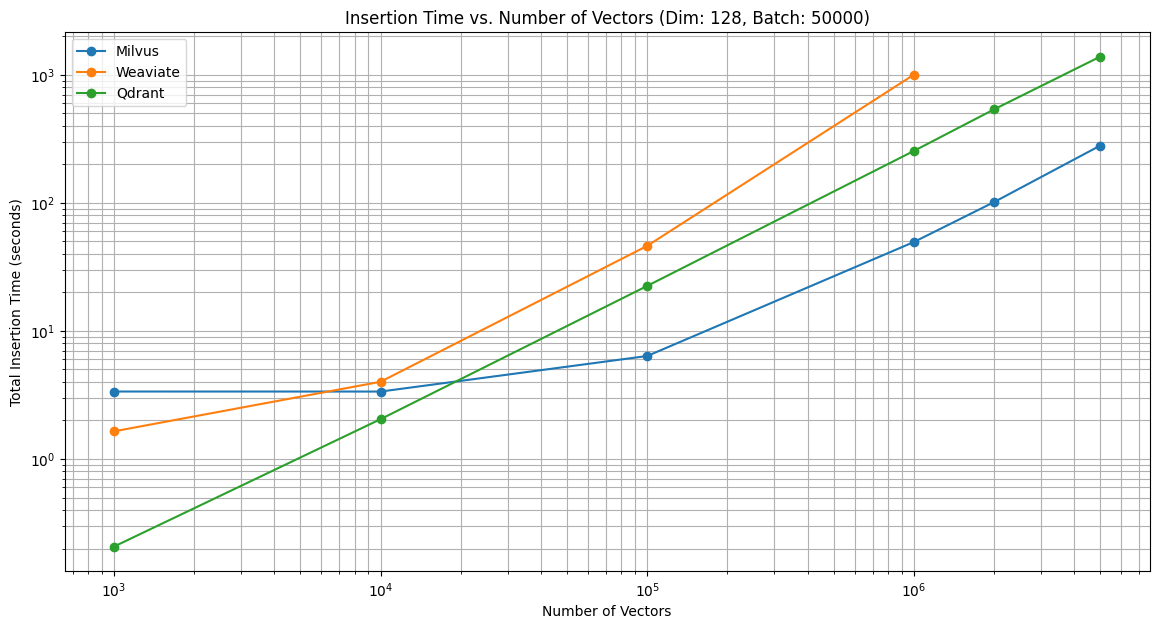

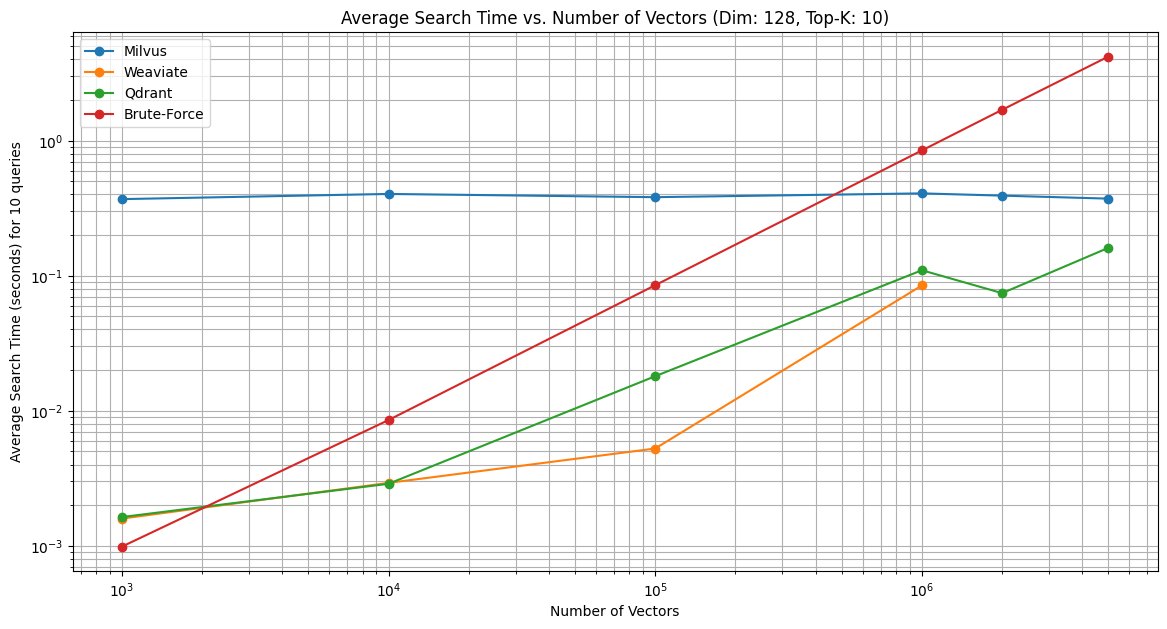

In [10]:
# Plotting the results
if not results_df.empty:
    # Ensure 'vectors' is numeric for plotting, handle potential NaNs if a test failed early
    results_df['vectors'] = pd.to_numeric(results_df['vectors'], errors='coerce')
    results_df['insert_time'] = pd.to_numeric(results_df['insert_time'], errors='coerce')
    results_df['search_time'] = pd.to_numeric(results_df['search_time'], errors='coerce')

    plt.style.use('default')  # Use default style instead of seaborn dependency 

    # Plot 1: Insertion Time vs. Number of Vectors
    plt.figure(figsize=(14, 7)) # Wider plot
    for db_name in results_df["db"].unique():
        if db_name == "Brute-Force": 
            continue
        db_data = results_df[results_df["db"] == db_name].dropna(subset=['vectors', 'insert_time'])
        if not db_data.empty:
            plt.plot(db_data["vectors"], db_data["insert_time"], marker='o', linestyle='-', label=db_name)
    
    plt.title(f'Insertion Time vs. Number of Vectors (Dim: {VECTOR_DIMENSION}, Batch: {DATA_INSERTION_BATCH_SIZE})')
    plt.xlabel('Number of Vectors')
    plt.ylabel('Total Insertion Time (seconds)')
    plt.legend()
    plt.grid(True, which="both", ls="-") # Grid for major and minor ticks on log scale
    plt.xscale('log') 
    plt.yscale('log') 
    plt.savefig(os.path.join(RESULTS_DIR, f"insertion_time_dim{VECTOR_DIMENSION}_batch{DATA_INSERTION_BATCH_SIZE}.png"))
    plt.show()

    # Plot 2: Average Search Time vs. Number of Vectors
    plt.figure(figsize=(14, 7)) # Wider plot
    for db_name in results_df["db"].unique():
        db_data = results_df[results_df["db"] == db_name].dropna(subset=['vectors', 'search_time'])
        if not db_data.empty:
            plt.plot(db_data["vectors"], db_data["search_time"], marker='o', linestyle='-', label=db_name)

    plt.title(f'Average Search Time vs. Number of Vectors (Dim: {VECTOR_DIMENSION}, Top-K: {TOP_K})')
    plt.xlabel('Number of Vectors')
    plt.ylabel(f'Average Search Time (seconds) for {NUM_QUERIES} queries')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig(os.path.join(RESULTS_DIR, f"search_time_dim{VECTOR_DIMENSION}_top{TOP_K}.png"))
    plt.show()
else:
    print("No results to plot. Please ensure the experiment ran correctly and produced data.")

In [11]:
def cleanup_all():
    # Milvus Cleanup
    if 'milvus_client_available' in globals() and milvus_client_available:
        try:
            connections.connect(host=MILVUS_HOST, port=MILVUS_PORT, alias="cleanup_milvus")
            if utility.has_collection(MILVUS_COLLECTION_NAME, using="cleanup_milvus"):
                utility.drop_collection(MILVUS_COLLECTION_NAME, using="cleanup_milvus")
                print(f"Cleaned up Milvus collection: {MILVUS_COLLECTION_NAME}")
            connections.disconnect("cleanup_milvus")
        except Exception as e:
            print(f"Error cleaning Milvus: {e}")

    # Weaviate Cleanup
    if 'weaviate_client_available' in globals() and weaviate_client_available:
        try:
            if weaviate_client.collections.exists(WEAVIATE_CLASS_NAME):
                weaviate_client.collections.delete(WEAVIATE_CLASS_NAME)
                print(f"Cleaned up Weaviate class: {WEAVIATE_CLASS_NAME}")
        except Exception as e:
            print(f"Error cleaning Weaviate (class might not exist): {e}")
    
    # Qdrant Cleanup
    if 'qdrant_client_available' in globals() and qdrant_client_available:
        try:
            if QDRANT_COLLECTION_NAME in [c.name for c in qdrant_client.get_collections().collections]:
                qdrant_clientx.delete_collection(collection_name=QDRANT_COLLECTION_NAME)
                print(f"Cleaned up Qdrant collection: {QDRANT_COLLECTION_NAME}")
        except Exception as e:
            print(f"Error cleaning Qdrant (collection might not exist): {e}")

print("Cleanup function defined. Call cleanup_all() if needed.")
# cleanup_all() # Uncomment to run cleanup

Cleanup function defined. Call cleanup_all() if needed.
